In [ ]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 3.8 MB/s eta 0:00:00


In [98]:
import torch
import torch.nn as nn
import torch.optim as optim
import json
import sacrebleu
import time

In [ ]:
# 1. Загрузка данных
def load_data(file_path, limit=None):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if limit and i >= limit:  # Останавливаемся после достижения лимита
                break
            data.append(json.loads(line))
    return data

# Загружаем обучающие данные с ограничением в 10,000 примеров
train_data = load_data("3/alien_translation/train.jsonl", limit=1000)
val_data = load_data("3/alien_translation/val.jsonl")

In [100]:
# 2. Создание словарей с гарантией добавления служебных токенов
# Функция для создания словаря
def build_vocab(datasets, key):
    vocab = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}  # Инициализация с служебными токенами
    idx = 4  # Начинаем индексацию с 4

    for item in datasets:
        for char in item[key]:  # Проходим по символам строки
            if char not in vocab:
                vocab[char] = idx
                idx += 1
    return vocab, len(vocab)
# Объединяем данные для создания словарей
all_data = train_data + val_data
src_vocab, src_vocab_size = build_vocab(all_data, "src")
dst_vocab, dst_vocab_size = build_vocab(all_data, "dst")

# Обратные словари для декодирования
src_rev_vocab = {v: k for k, v in src_vocab.items()}
dst_rev_vocab = {v: k for k, v in dst_vocab.items()}


In [101]:
# 3. Токенизация
def encode(sentence, vocab, add_eos=True):
    tokens = [vocab.get(char, vocab["<UNK>"]) for char in sentence]  # Используем <UNK> для неизвестных символов
    if add_eos:
        tokens.append(vocab["<EOS>"])
    return tokens

In [102]:
# 4. Модель Seq2Seq с GRU
class Seq2Seq(nn.Module):
    def __init__(self, src_vocab_size, dst_vocab_size, embed_size, hidden_size):
        super(Seq2Seq, self).__init__()
        self.encoder = nn.Embedding(src_vocab_size, embed_size)
        self.decoder = nn.Embedding(dst_vocab_size, embed_size)
        self.enc_gru = nn.GRU(embed_size, hidden_size, batch_first=True)
        self.dec_gru = nn.GRU(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, dst_vocab_size)

    def forward(self, src, dst):
        # Encoder
        src_embed = self.encoder(src)
        _, hidden = self.enc_gru(src_embed)

        # Decoder
        dst_embed = self.decoder(dst)
        outputs, _ = self.dec_gru(dst_embed, hidden)
        logits = self.fc(outputs)
        return logits

In [103]:
import matplotlib.pyplot as plt

def train_model(model, train_data, src_vocab, dst_vocab, epochs=5, lr=0.001):
    loss_fn = nn.CrossEntropyLoss(ignore_index=0)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    epoch_losses = []

    for epoch in range(epochs):
        model.train()
        start_time = time.time()
        epoch_loss = 0

        for item in train_data:
            src = torch.tensor(encode(item["src"], src_vocab), dtype=torch.long).unsqueeze(0)
            dst = torch.tensor(encode(item["dst"], dst_vocab), dtype=torch.long).unsqueeze(0)
            target = dst[:, 1:]

            logits = model(src, dst[:, :-1])
            loss = loss_fn(logits.reshape(-1, dst_vocab_size), target.reshape(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        epoch_losses.append(epoch_loss)
        end_time = time.time()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Time: {end_time - start_time:.2f}s")

    # Построение графика
    plt.plot(range(1, epochs + 1), epoch_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.show()


In [104]:

# 6. Инференс
def translate(model, sentence, src_vocab, dst_vocab, max_len=50):
    model.eval()
    src = torch.tensor(encode(sentence, src_vocab), dtype=torch.long).unsqueeze(0)
    with torch.no_grad():
        _, hidden = model.enc_gru(model.encoder(src))
        dec_input = torch.tensor([[dst_vocab["<SOS>"]]], dtype=torch.long)
        output_sentence = []
        for _ in range(max_len):
            dec_embed = model.decoder(dec_input)
            output, hidden = model.dec_gru(dec_embed, hidden)
            logits = model.fc(output.squeeze(1))
            token = logits.argmax(1).item()
            if token == dst_vocab["<EOS>"]:
                break
            output_sentence.append(token)
            dec_input = torch.tensor([[token]], dtype=torch.long)
    return "".join([dst_rev_vocab[token] for token in output_sentence])


In [105]:

# 7. Оценка BLEU
def evaluate_bleu(model, val_data, src_vocab, dst_vocab):
    predictions = []
    references = []

    for item in val_data:
        src_sentence = item["src"]
        ref_sentence = item["dst"]

        # Генерация перевода
        predicted_sentence = translate(model, src_sentence, src_vocab, dst_vocab)

        predictions.append(predicted_sentence)
        references.append([ref_sentence])  # BLEU ожидает список референсов

    # Вычисление BLEU
    bleu = sacrebleu.corpus_bleu(predictions, references)
    print(f"BLEU Score: {bleu.score:.2f}")
    return bleu.score


Epoch 1/5, Loss: 2249.1491, Time: 55.44s
Epoch 2/5, Loss: 1843.3931, Time: 55.39s
Epoch 3/5, Loss: 1660.5182, Time: 53.92s
Epoch 4/5, Loss: 1513.1387, Time: 54.63s
Epoch 5/5, Loss: 1380.1435, Time: 53.53s


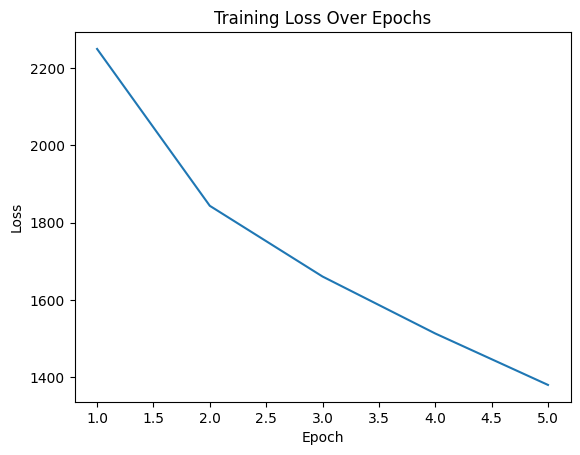

In [106]:
embed_size = 128
hidden_size = 256
model = Seq2Seq(src_vocab_size, dst_vocab_size, embed_size, hidden_size)

train_model(model, train_data, src_vocab, dst_vocab, epochs=5)
bleu_score = evaluate_bleu(model, val_data, src_vocab, dst_vocab)

In [ ]:
# Перевод тестовых данных с сохранением в нужном формате
test_data = load_data("3/alien_translation/test_no_reference.jsonl")

with open("test_translations.jsonl", "w", encoding="utf-8") as f:
    for item in test_data:
        src_sentence = item["src"]
        translation = translate(model, src_sentence, src_vocab, dst_vocab)
        # Меняем порядок ключей, как требуется
        json.dump({"dst": translation, "src": src_sentence}, f, ensure_ascii=False)  # ensure_ascii=False для читаемости
        f.write("\n")

print("Переводы сохранены в файл test_translations.jsonl в заданном формате.")


Переводы сохранены в файл test_translations.jsonl в заданном формате.


In [118]:
test_sentence = "▤◧◞◪▦◞▫◪◗▦"
print(translate(model, test_sentence, src_vocab, dst_vocab))

ow you can the fuck of a bitch.


In [119]:
import json

# Функция для чтения JSONL и преобразования Unicode-символов в читаемый формат
def read_jsonl(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = [json.loads(line) for line in f]
    return data

# Загружаем данные
test_translations = read_jsonl("test_translations.jsonl")

# Выводим пример для проверки
for item in test_translations[:5]:  # Показываем первые 5 записей
    print("Source (src):", item["src"])
    print("Target (dst):", item["dst"])
    print()


Source (src): ◲▦◠▦◬▦■ ◉◗▢◕◗ ◍◗▱◎ ▽◠▽▪▦◠ ◕▴◉◗▦▼▴ ◀◗◓◉◧▨ ◎▴◞◠▸ ◠▱◈▪▨ ◚◪ ◀◨ ◎◪◞◠▸▱◠◓◬▦ ◀◠▢▪▱◠◓▪ ▻◪▨ ◈◂◞▫◉◠ ◈▴◐◫▱◈◗▵
Target (dst): ow have to be the beginning the becort.

Source (src): ▯▴▥ ◟◧◓▨▱◨ ◀◫◓ ◈◠◈◬■ ◉◂▼◨◐◨▦ ◠▦▦◪◞◗▦◗▦ ▽◠▢◈◬◐▪ ◚◪ ◳◠▦▱▪◒▱▪▨▱◠ ▨▴▦◈◗◞◗▦▴ ◕◣▦◈▴◓◈◗◐◫■ "◀◫◓ ◞◫◳◠▷◗ ◈◠▷◠" ◳◠▢◠▦ ◀◗◓ ◎▴◞◠▸◈◠▦ ◞◧▦◓◠ ▨◪▦◈◫◞◗▦◪ ◠◳◓▪◎▼◬▱◬▨ ◳◠▻▪▱◈▪◐▪ ◚◪ ◗◒◫▦◈◪▦ ▨◂◚◨▱◈▾◐▾ ◫◉◫▦ ◉◗◍▫▴ ◈◠◚◠ ◠◉◬▽◂◓▵
Target (dst): oney?

Source (src): ◡◠▻◧▦ ◂▫◧◎◂◀◗▱ ◍◗◓◎◠◞◬ ◠▦▱◠◒◎◠◞▪▢ ◝◓▴▹◗▫ ◈◨◓▾◎▾▦◈◠ ◞▪▦◬◓◈◠ ◀◪▨▱▴◎◪ ◞◭◓◪◞◫▦◫▦ ◨▢◠◎◠◞▪▦▪▦ ◫▦◞◠▦▱◠◓▪▦ ◗◒◗▦◫ ▨◠▽◀◪▫◎◪◞◫▦◪ ▦▴◈◪▦ ◂▱◠◀◫▱▴▼▴◐◫▦◫ ◞◇◳▱◪◈◗▵
Target (dst): ook you are the real of the bring the becort.

Source (src): ◝▾◀◀◠ ▰◠▫◞◂▦ ◚▴ ▰▴◀◀ ▮◫◎▻◞◂▦■ ◞◠◀◠▷ ◂◳▦◠▦◠▦ ◍◂◨◓◀◠▱▱ ◎◠◉▱◠◓▪▦▪▦ ▨◠▷◓◠◎◠▦▪ ▮▴◓◕◫◧ ◆◠◓▼◗◠'▽◬ ◚◪ ○▱▴▹ ▯◂◓▴▦ ◫▱▴ ▴◒▱▴◒▫◗◐◫ ◎◠◉▫◠ ▨◬◞◠ ◞▩◓◪◈◪ ◎◠◐▱▾▻ ▴▫▫◗▵
Target (dst):  an are the real of the bring the becort.

Source (src): "○◐▱◠◈◬◐▪▦▪ ◕◣◓◎◪▱◪◓◗▦◪ ◠◞▱◠ ◗▢◫▦ ◚▴◓◎▴■" ◈◪◈◫ ◀◠▦◠▵
Target (dst): ook be the beginning the becort.



In [120]:
# Сохранение модели после обучения
torch.save(model.state_dict(), "translator_from_alien_to_english.pth")

In [121]:
# Загрузка модели в будущем для инференса
# Создаём модель с теми же параметрами
model = Seq2Seq(src_vocab_size, dst_vocab_size, embed_size, hidden_size)

# Загружаем сохранённые параметры
model.load_state_dict(torch.load("translator_from_alien_to_english.pth"))
model.eval()  # Переводим модель в режим инференса

# Пример использования модели для инференса
src_sentence = "◱ ◒◂◍◣◓▩▦ ◗◞◎◗ ▦◪▽◈◫ ▫▴▨◓◠◓ ◞◣▽▱▴◓ ◎◗◞◗▦?"
translation = translate(model, src_sentence, src_vocab, dst_vocab) # Идеальный перевод: What'd you say this driver's name was again?
print(f"Перевод: {translation}")

Перевод: ow baby!


<ipython-input-121-950e7580cf05>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("translator_from_alien_to_english.pth"))
